## Agente basico : 1 inicio 1 agente(llm) 1 fin

## Importaciones

In [ ]:
from typing import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import MemorySaver #Obtener el objeto en memoria
from langgraph.prebuilt import ToolNode, tools_condition # Añadir un o mas tools
from langchain_core.messages import HumanMessage

In [ ]:
memory = MemorySaver() #Crear el objeto memory saver

In [60]:
''' 
Definimos la tools, recomendable que siempre sean funciones y añadir documentacion a la funcion para
darle contexto al LLM
'''
def sumar(a: int, b: int) -> int:
    """Suma dos enteros.
    Args:
        a: Primer entero
        b: Segundo entero
    """
    return a + b

In [61]:
''' 
Definimos el estado de los datos que van a fluir por el grafo
en este caso un diccionario con una clave llamada messages que 
contendra una lista de mensajes (que a su vez son diccionarios) con la forma 


state = {
    "messages": [
        {
            "role": "user",
            "content": "Hola, ¿cómo estás?"
        },
        {
            "role": "assistant",
            "content": "Estoy bien, ¿en qué puedo ayudarte?"
        },
        {
            "role": "user",
            "content": "Explícame cómo funciona LangGraph"
        }
    ]
}

''' 

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [62]:
''' 
Cuando ejecutas esta línea:

Creas un nuevo constructor de grafo (un objeto StateGraph)
Le dices a este constructor que los datos que fluirán por el grafo tendrán la forma definida en la clase State
El constructor ahora sabe que debe esperar un diccionario con una clave messages que contendrá una lista

Es como preparar el lienzo antes de empezar a dibujar.
'''

graph_builder = StateGraph(State)

In [63]:
''' 
Definimos una lista para las tools
'''

tools = [sumar]

In [64]:
''' 
Definimos el LLM que vamos a usar en nuestro caso Gemini de VertexAI

Aqui usamos langchain para definir el modelo que vamos a usar

para cada LLM se importa de diferente manera en nuestro caso usamos ChatVertexAI

from langchain_google_vertexai import ChatVertexAI

''' 
from langchain_google_vertexai import ChatVertexAI
llm = ChatVertexAI(model="gemini-2.0-flash-001",temperature=0)


''' 
Sobre escribimos el LLM para que use las tools
'''

llm = llm.bind_tools(tools)

In [65]:
''' 
La línea def chatbot(state: State): está definiendo una función llamada "chatbot" que espera recibir un parámetro llamado "state".
La parte state: State es una "anotación de tipo" en Python, y hace lo siguiente:

state es el nombre del parámetro que recibirá la función
Los dos puntos : indican que estamos especificando el tipo de este parámetro
State (que definimos anteriormente como una TypedDict) indica que el parámetro debe tener la estructura especificada en la clase State

Es como poner una etiqueta en una caja que dice: "Esta función espera recibir una caja (state) que debe tener exactamente la forma descrita en el plano State".

'''

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [66]:
'''
Creamos nuestro primer todo (primer nuestro tercero de langgraph)
START Y END vienen por defecto 

"chatbot" - Este es el nombre o etiqueta que le estás dando al nodo. 
Es como ponerle un cartel a una estación de trabajo para identificarla. 
Cuando quieras referirte a este nodo más adelante (por ejemplo, para conectarlo con otros), usarás este nombre.

chatbot - Esta es la función que definiste anteriormente. Le estás diciendo al grafo: 
"Cuando el flujo llegue a este nodo, ejecuta esta función". Es la tarea específica que se realizará en esta estación.
'''

graph_builder.add_node("chatbot", chatbot)

''' 
Debemos crear una nodo adicional para desplegar las tools y adicional conectar ese nodo con el resto del grafo 
'''
graph_builder.add_node("tools",ToolNode(tools)) #Nodo de Tools


In [67]:
''' 
START - Este es un nodo especial predefinido en LangGraph que representa el punto de inicio del flujo. Es como la puerta de entrada a tu diagrama.
'chatbot' - Este es el nombre del nodo al que quieres conectar el inicio. Debe ser un nodo que ya hayas añadido con add_node().
'''

graph_builder.add_edge(START, "chatbot")

'''
Nodo especial de langgraph con el cual se puede manejar la condicion de content interna
'''
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot") # Conexion de nodo llm con tools
graph_builder.add_edge("chatbot", END)

In [ ]:
''' 
La diferencia entre graph_builder y graph es importante:

graph_builder es la herramienta de diseño (el plano)
graph es el producto final listo para usar (la fábrica construida)
'''

graph = graph_builder.compile(checkpointer=memory) #Crear el checkpointer hacia memory

In [69]:
''' 
De esta manera se maneja el contexto, para langraph dev no se usa esto la interfaz lo hace por si misma
'''

# result = graph.invoke(
#                         {"messages": 
#                                     [
#                                         {"role": "user", "content": "Hola"},
#                                         {"role": "assistant", "content": "¡Hola! ¿En qué puedo ayudarte hoy?\n"},
#                                         {"role": "user", "content": "Dime cuanto es 2 + 2"},
#                                         {"role": "assistant", "content": "2 + 2 = 4\n"},
#                                         {"role": "user", "content": "Al resultado anterior sumale 8"}
                                    
#                                     ]
#                         }
                    
#                     )
# result

' \nDe esta manera se maneja el contexto, para langraph dev no se usa esto la interfaz lo hace por si misma\n'

In [ ]:
config = {"configurable": {"thread_id": "2"}} #Debe ser unico para que se guarde el contexto de la conversacion
input_message = HumanMessage(input("Mensaje"))
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


input_message = HumanMessage(input("Mensaje"))
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


input_message = HumanMessage(input("Mensaje"))
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hola mi nombre es juan
================================== Ai Message ==================================

Hola Juan, encantado de conocerte. ¿En qué puedo ayudarte hoy?
================================ Human Message =================================

cuando es 2 +2 
================================== Ai Message ==================================
Tool Calls:
  sumar (a205f28d-923b-47c8-aba2-2a8da54414d8)
 Call ID: a205f28d-923b-47c8-aba2-2a8da54414d8
  Args:
    a: 2.0
    b: 2.0
================================= Tool Message =================================
Name: sumar

4
================================== Ai Message ==================================

2 + 2 = 4
================================ Human Message =================================

recuerdas mi nombre?
================================== Ai Message ==================================

Sí, tu nombre es Juan.


Grafo de mi agente

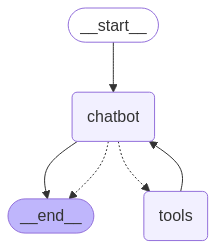

In [74]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)
    pass

In [75]:
config = {"configurable": {"thread_id": "3"}} # 
input_message = HumanMessage(input("Mensaje"))
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


input_message = HumanMessage(input("Mensaje"))
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


input_message = HumanMessage(input("Mensaje"))
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hola recuerdas mi nombre?
================================== Ai Message ==================================

No tengo memoria. No recuerdo nombres.
================================ Human Message =================================

no me hables tan seco
================================== Ai Message ==================================

Entiendo. Intentaré ser más amigable. ¿Cómo puedo ayudarte hoy?
================================ Human Message =================================

dime cuanto es 2 +2  
================================== Ai Message ==================================
Tool Calls:
  sumar (b9459217-3a07-4c37-a4be-5b93005eef09)
 Call ID: b9459217-3a07-4c37-a4be-5b93005eef09
  Args:
    a: 2.0
    b: 2.0
================================= Tool Message =================================
Name: sumar

4
================================== Ai Message ==================================

El resultado de 2 + 2 